## Parcial Final ML

### Presentado por: Angel Pineda

## EDA

In [1]:
import warnings
warnings.filterwarnings('ignore')
import mglearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


### Fraud Detection

#### Lectura de dataset

In [4]:
train_transaction = pd.read_csv('train_transaction.csv')
train_identity = pd.read_csv('train_identity.csv')


In [5]:
def reduce_mem_usage(df):

    start_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    start_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    print(f'Initial memory usage of dataframe is {start_mem:.2f} MB/{start_mem_GB:.2f} GB')
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage(index=True, deep=True).sum() / 1024**2
    end_mem_GB = df.memory_usage(index=True, deep=True).sum() / 1024**3
    reduction = 100 * (start_mem - end_mem) / start_mem
    print(f'Memory usage after optimization is: {end_mem:.2f} MB/{end_mem_GB:.2f} GB')
    print(f'Decreased by {reduction:.1f}%')
    
    return df

In [6]:
train_transaction =  reduce_mem_usage(train_transaction)
train_identity = reduce_mem_usage(train_identity)

Initial memory usage of dataframe is 2100.70 MB/2.05 GB
Memory usage after optimization is: 487.17 MB/0.48 GB
Decreased by 76.8%
Initial memory usage of dataframe is 157.63 MB/0.15 GB
Memory usage after optimization is: 10.14 MB/0.01 GB
Decreased by 93.6%


In [7]:
train_fraud = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')

In [8]:
train_fraud =  train_fraud.iloc[:100000]

In [9]:
del train_transaction
del train_identity


In [10]:
train_fraud.head()

TransactionID  isFraud  TransactionDT  TransactionAmt ProductCD  card1  \
0        2987000        0          86400            68.5         W  13926   
1        2987001        0          86401            29.0         W   2755   
2        2987002        0          86469            59.0         W   4663   
3        2987003        0          86499            50.0         W  18132   
4        2987004        0          86506            50.0         H   4497   

   card2  card3       card4  card5  ...                id_31  id_32  \
0    NaN  150.0    discover  142.0  ...                  NaN    NaN   
1  404.0  150.0  mastercard  102.0  ...                  NaN    NaN   
2  490.0  150.0        visa  166.0  ...                  NaN    NaN   
3  567.0  150.0  mastercard  117.0  ...                  NaN    NaN   
4  514.0  150.0  mastercard  102.0  ...  samsung browser 6.2   32.0   

       id_33           id_34  id_35 id_36 id_37  id_38  DeviceType  \
0        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
1        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
2        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
3        NaN             NaN    NaN   NaN   NaN    NaN         NaN   
4  2220x1080  match_status:2      T     F     T      T      mobile   

                      DeviceInfo  
0                            NaN  
1                            NaN  
2                            NaN  
3                            NaN  
4  SAMSUNG SM-G892A Build/NRD90M  

[5 rows x 434 columns]

In [11]:
train_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 89.1 MB


In [12]:
train_fraud.describe()

TransactionID       isFraud  TransactionDT  TransactionAmt  \
count   1.000000e+05  100000.00000   1.000000e+05   100000.000000   
mean    3.037000e+06       0.02561   1.135124e+06             NaN   
std     2.886766e+04       0.15797   5.733484e+05             NaN   
min     2.987000e+06       0.00000   8.640000e+04        0.291992   
25%     3.012000e+06       0.00000   6.537488e+05       45.000000   
50%     3.037000e+06       0.00000   1.189342e+06       75.000000   
75%     3.061999e+06       0.00000   1.643471e+06      136.000000   
max     3.086999e+06       1.00000   2.006364e+06     4828.000000   

              card1    card2    card3    card5    addr1    addr2  ...  \
count  100000.00000  98646.0  99997.0  99475.0  90963.0  90963.0  ...   
mean     9878.39890      NaN      NaN      NaN      NaN      NaN  ...   
std      4933.56307      NaN      0.0      0.0      NaN      0.0  ...   
min      1001.00000    100.0    100.0    100.0    100.0     13.0  ...   
25%      6019.00000    215.0    150.0    166.0    204.0     87.0  ...   
50%      9653.00000    387.0    150.0    226.0    299.0     87.0  ...   
75%     14290.00000    514.0    150.0    226.0    330.0     87.0  ...   
max     18395.00000    600.0    229.0    237.0    540.0    102.0  ...   

             id_17         id_18    id_19    id_20   id_21        id_22  \
count  39880.00000  1.298100e+04  39871.0  39866.0  1620.0  1624.000000   
mean           inf           inf      inf      inf     inf    15.515625   
std       25.65625  1.479492e+00      inf      inf     inf     6.054688   
min      100.00000  1.100000e+01    100.0    100.0   100.0    12.000000   
25%      166.00000  1.300000e+01    266.0    222.0   252.0    14.000000   
50%      166.00000  1.300000e+01    352.0    391.0   252.0    14.000000   
75%      166.00000  1.500000e+01    492.0    521.0   576.0    14.000000   
max      229.00000  2.900000e+01    671.0    660.0   853.0    41.000000   

             id_24      id_25      id_26         id_32  
count  1500.000000  1612.0000  1623.0000  2.983800e+04  
mean     13.226562        inf        inf           inf  
std       2.179688   104.0625    31.0625  3.654297e+00  
min      11.000000   100.0000   100.0000  0.000000e+00  
25%      11.000000   272.0000   121.0000  2.400000e+01  
50%      15.000000   321.0000   150.0000  2.400000e+01  
75%      15.000000   381.0000   169.0000  3.200000e+01  
max      25.000000   548.0000   216.0000  3.200000e+01  

[8 rows x 403 columns]

In [13]:
train_fraud.isnull().sum()

# Calcular la cantidad de valores nulos en porcentaje para cada columna
porcentaje_nulos = (train_fraud.isnull().sum() / len(train_fraud)) * 100

# 'porcentaje_nulos' ahora contiene el porcentaje de valores nulos para cada columna
print(f'Porcentaje de valores nulos')

print(porcentaje_nulos)

print('')
print(f'Numero de datos faltantes')
print(train_fraud.isnull().sum())

Porcentaje de valores nulos
TransactionID      0.000
isFraud            0.000
TransactionDT      0.000
TransactionAmt     0.000
ProductCD          0.000
                   ...  
id_36             59.599
id_37             59.599
id_38             59.599
DeviceType        59.717
DeviceInfo        63.535
Length: 434, dtype: float64

Numero de datos faltantes
TransactionID         0
isFraud               0
TransactionDT         0
TransactionAmt        0
ProductCD             0
                  ...  
id_36             59599
id_37             59599
id_38             59599
DeviceType        59717
DeviceInfo        63535
Length: 434, dtype: int64


* 

In [14]:
porcentaje_nulos.info

<bound method Series.info of TransactionID      0.000
isFraud            0.000
TransactionDT      0.000
TransactionAmt     0.000
ProductCD          0.000
                   ...  
id_36             59.599
id_37             59.599
id_38             59.599
DeviceType        59.717
DeviceInfo        63.535
Length: 434, dtype: float64>

In [15]:
train_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float16(354), float32(45), int16(1), int32(2), int8(1)
memory usage: 89.1 MB


* Aqui se codifican las variables categoricas con OneHotEncoder

In [16]:
from sklearn.preprocessing import OneHotEncoder
variables_categoricas = train_fraud.select_dtypes(include=['category']).columns.tolist()

# Crear una instancia de OneHotEncoder
oh= OneHotEncoder(sparse_output=False, drop='first').set_output(transform="pandas")

# Ajustar y transformar las columnas categóricas
one_hot_encoded = oh.fit_transform(train_fraud[variables_categoricas])

train_fraud = pd.concat([train_fraud,one_hot_encoded],axis=1)

train_fraud = train_fraud.drop(columns=variables_categoricas)

In [17]:
train_fraud

TransactionID  isFraud  TransactionDT  TransactionAmt  card1  card2  \
0            2987000        0          86400         68.5000  13926    NaN   
1            2987001        0          86401         29.0000   2755  404.0   
2            2987002        0          86469         59.0000   4663  490.0   
3            2987003        0          86499         50.0000  18132  567.0   
4            2987004        0          86506         50.0000   4497  514.0   
...              ...      ...            ...             ...    ...    ...   
99995        3086995        0        2005989         55.3750   2256  545.0   
99996        3086996        0        2006074        117.0000   2518  555.0   
99997        3086997        0        2006135         50.0000   2748  111.0   
99998        3086998        0        2006177        100.0000  16075  514.0   
99999        3086999        0        2006364        107.9375   4436  174.0   

       card3  card5  addr1  addr2  ...  DeviceInfo_rv:52.0  \
0      150.0  142.0  315.0   87.0  ...                 0.0   
1      150.0  102.0  325.0   87.0  ...                 0.0   
2      150.0  166.0  330.0   87.0  ...                 0.0   
3      150.0  117.0  476.0   87.0  ...                 0.0   
4      150.0  102.0  420.0   87.0  ...                 0.0   
...      ...    ...    ...    ...  ...                 ...   
99995  185.0  226.0    NaN    NaN  ...                 0.0   
99996  150.0  226.0  512.0   87.0  ...                 0.0   
99997  150.0  228.0  441.0   87.0  ...                 0.0   
99998  150.0  102.0  299.0   87.0  ...                 0.0   
99999  150.0  226.0  330.0   87.0  ...                 0.0   

       DeviceInfo_rv:53.0  DeviceInfo_rv:54.0  DeviceInfo_rv:55.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
99995                 0.0                 0.0                 0.0   
99996                 0.0                 0.0                 0.0   
99997                 0.0                 0.0                 0.0   
99998                 0.0                 0.0                 0.0   
99999                 0.0                 0.0                 0.0   

       DeviceInfo_rv:56.0  DeviceInfo_rv:57.0  DeviceInfo_rv:58.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
99995                 0.0                 0.0                 0.0   
99996                 0.0                 0.0                 0.0   
99997                 0.0                 0.0                 0.0   
99998                 0.0                 0.0                 0.0   
99999                 0.0                 0.0                 0.0   

       DeviceInfo_verykoolS5019  DeviceInfo_verykoolS5525  DeviceInfo_nan  
0                           0.0                       0.0             1.0  
1                           0.0                       0.0             1.0  
2                           0.0                       0.0             1.0  
3                           0.0                       0.0             1.0  
4                           0.0                       0.0             0.0  
...                         ...                       ...             ...  
99995                       0.0                       0.0             1.0  
99996                       0.0                       0.0  

In [18]:
from sklearn.impute import SimpleImputer

columnas = train_fraud.columns
# Crear un objeto SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

# Ajustar el imputer a los datos
imp.fit(train_fraud)

# Transformar el DataFrame para reemplazar los valores faltantes con la mediana de cada columna
train_fraud = imp.transform(train_fraud)

In [19]:
print("\nDataFrame con valores faltantes reemplazados por la mediana:")
train_fraud = pd.DataFrame(train_fraud , columns=columnas)
print(train_fraud.head)


DataFrame con valores faltantes reemplazados por la mediana:
<bound method NDFrame.head of        TransactionID  isFraud  TransactionDT  TransactionAmt    card1  card2  \
0          2987000.0      0.0        86400.0         68.5000  13926.0  387.0   
1          2987001.0      0.0        86401.0         29.0000   2755.0  404.0   
2          2987002.0      0.0        86469.0         59.0000   4663.0  490.0   
3          2987003.0      0.0        86499.0         50.0000  18132.0  567.0   
4          2987004.0      0.0        86506.0         50.0000   4497.0  514.0   
...              ...      ...            ...             ...      ...    ...   
99995      3086995.0      0.0      2005989.0         55.3750   2256.0  545.0   
99996      3086996.0      0.0      2006074.0        117.0000   2518.0  555.0   
99997      3086997.0      0.0      2006135.0         50.0000   2748.0  111.0   
99998      3086998.0      0.0      2006177.0        100.0000  16075.0  514.0   
99999      3086999.0      0.

* Ya se han rellenado los datos con la mediana y por lo tanto podemos ver que no se encuentran datos nulos.

In [20]:
train_fraud.isnull().sum()


TransactionID               0
isFraud                     0
TransactionDT               0
TransactionAmt              0
card1                       0
                           ..
DeviceInfo_rv:57.0          0
DeviceInfo_rv:58.0          0
DeviceInfo_verykoolS5019    0
DeviceInfo_verykoolS5525    0
DeviceInfo_nan              0
Length: 1729, dtype: int64

In [21]:
train_fraud

TransactionID  isFraud  TransactionDT  TransactionAmt    card1  card2  \
0          2987000.0      0.0        86400.0         68.5000  13926.0  387.0   
1          2987001.0      0.0        86401.0         29.0000   2755.0  404.0   
2          2987002.0      0.0        86469.0         59.0000   4663.0  490.0   
3          2987003.0      0.0        86499.0         50.0000  18132.0  567.0   
4          2987004.0      0.0        86506.0         50.0000   4497.0  514.0   
...              ...      ...            ...             ...      ...    ...   
99995      3086995.0      0.0      2005989.0         55.3750   2256.0  545.0   
99996      3086996.0      0.0      2006074.0        117.0000   2518.0  555.0   
99997      3086997.0      0.0      2006135.0         50.0000   2748.0  111.0   
99998      3086998.0      0.0      2006177.0        100.0000  16075.0  514.0   
99999      3086999.0      0.0      2006364.0        107.9375   4436.0  174.0   

       card3  card5  addr1  addr2  ...  DeviceInfo_rv:52.0  \
0      150.0  142.0  315.0   87.0  ...                 0.0   
1      150.0  102.0  325.0   87.0  ...                 0.0   
2      150.0  166.0  330.0   87.0  ...                 0.0   
3      150.0  117.0  476.0   87.0  ...                 0.0   
4      150.0  102.0  420.0   87.0  ...                 0.0   
...      ...    ...    ...    ...  ...                 ...   
99995  185.0  226.0  299.0   87.0  ...                 0.0   
99996  150.0  226.0  512.0   87.0  ...                 0.0   
99997  150.0  228.0  441.0   87.0  ...                 0.0   
99998  150.0  102.0  299.0   87.0  ...                 0.0   
99999  150.0  226.0  330.0   87.0  ...                 0.0   

       DeviceInfo_rv:53.0  DeviceInfo_rv:54.0  DeviceInfo_rv:55.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
99995                 0.0                 0.0                 0.0   
99996                 0.0                 0.0                 0.0   
99997                 0.0                 0.0                 0.0   
99998                 0.0                 0.0                 0.0   
99999                 0.0                 0.0                 0.0   

       DeviceInfo_rv:56.0  DeviceInfo_rv:57.0  DeviceInfo_rv:58.0  \
0                     0.0                 0.0                 0.0   
1                     0.0                 0.0                 0.0   
2                     0.0                 0.0                 0.0   
3                     0.0                 0.0                 0.0   
4                     0.0                 0.0                 0.0   
...                   ...                 ...                 ...   
99995                 0.0                 0.0                 0.0   
99996                 0.0                 0.0                 0.0   
99997                 0.0                 0.0                 0.0   
99998                 0.0                 0.0                 0.0   
99999                 0.0                 0.0                 0.0   

       DeviceInfo_verykoolS5019  DeviceInfo_verykoolS5525  DeviceInfo_nan  
0                           0.0                       0.0             1.0  
1                           0.0                       0.0             1.0  
2                           0.0                       0.0             1.0  
3                           0.0                       0.0             1.0  
4                           0.0                       0.0             0.0  
...                         ...                       ...             ...  
99995                       0.0                       0.0             1.0  
99996                       0.0    

#### Reduccion de dimensionalidad

In [22]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

X = train_fraud.drop(columns='isFraud') # Reemplaza con tus nombres de columna

vif = pd.DataFrame()
vif["Variable"] = columnas
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    

In [ ]:
vif

### Wind Speed

In [136]:
wind_speed=pd.read_csv('data_treino_dv_df_2000_2010.csv')

En este Dataset se encuentran el siguiente tipo de Variables: 
* HORA (UTC): Hora
* VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr)): Dirección del viento horaria
* VENTO, VELOCIDADE HORARIA (m/s): Velocidad horario del viento (m/s)
* UMIDADE REL. MAX. NA HORA ANT. (AUT) ( %): Humedad rel. máx. hora anterior (AUT) ( %)
* UMIDADE REL. MIN. NA HORA ANT. (AUT) ( %): Humedad rel. mín. hora anterior (AUT) ( %) 
* TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C): Temperatura máx. hora anterior (AUT) (℃)
* TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C): Temperatura mín. hora anterior (AUT) ( ℃)
* UMIDADE RELATIVA DO AR, HORARIA ( %): Humedad relativa horaria ( %)
* PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB): Presión atmosférica a nivel de estación, horaria (mB)
* PRECIPITACION TOTAL, HORARIO (mm): Precipitación total por hora (mm)
* VENTO, RAJADA MAXIMA (m/s): Máxima ráfaga de viento (m/s)
* PRESSï¿½O ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB): Presión atmosférica máx. hora anterior (AUT) (mB)
* PRESSï¿½O ATMOSFERICA MIN.NA HORA ANT. (AUT) (mB): Presión atmosférica mín. hora anterior (AUT) (mB)

In [137]:
wind_speed

HORA (UTC)  VENTO, DIREï¿½ï¿½O HORARIA (gr) (ï¿½ (gr))  \
0          12:00                                    0.809017   
1          13:00                                    0.965926   
2          14:00                                    0.891007   
3          15:00                                    0.848048   
4          16:00                                    0.224951   
...          ...                                         ...   
87688      19:00                                   -0.615661   
87689      20:00                                   -0.469472   
87690      21:00                                   -0.484810   
87691      22:00                                   -0.484810   
87692      23:00                                   -0.573576   

       VENTO, VELOCIDADE HORARIA (m/s)  \
0                                  1.8   
1                                  2.7   
2                                  2.0   
3                                  2.5   
4                                  2.4   
...                                ...   
87688                              5.6   
87689                              4.9   
87690                              4.5   
87691                              3.2   
87692                              2.3   

       UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)  \
0                                          69.0   
1                                          62.0   
2                                          56.0   
3                                          52.0   
4                                          50.0   
...                                         ...   
87688                                      83.0   
87689                                      84.0   
87690                                      86.0   
87691                                      88.0   
87692                                      95.0   

       UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)  \
0                                          60.0   
1                                          55.0   
2                                          50.0   
3                                          44.0   
4                                          43.0   
...                                         ...   
87688                                      78.0   
87689                                      79.0   
87690                                      82.0   
87691                                      85.0   
87692                                      88.0   

       TEMPERATURA Mï¿½XIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                22.6   
1                                                24.2   
2                                                25.5   
3                                                27.4   
4                                                27.1   
...                                               ...   
87688                                            21.8   
87689                                            21.7   
87690                                            21.2   
87691                                            20.6   
87692                                            20.2   

       TEMPERATURA Mï¿½NIMA NA HORA ANT. (AUT) (ï¿½C)  \
0                                                20.7   
1                                                22.5   
2                                                24.3   
3                                                25.0   
4                                                25.5   
...                                               ...   
87688                                            21.1   
87689                                            21.0   
87690                                            20.6   
87691                                            20.2   
87692                                            19.3   

       UMIDADE RELATIVA DO AR, HORARIA (%)  \
0                                     61.0   
1                                     55.0  

In [138]:
nuevos_nombres = ['Hora', 'dir_viento', 'vel_viento', 'Humedad rel. máx','Humedad rel. mín.','Temp. máx','Temp mín.', 'Humedad rel horaria', 'Presión atm', 'Precip', 'Máx ráfaga', 'Presión atm máx', 'Presión atm mín']

In [139]:
wind_speed.columns = nuevos_nombres

In [140]:
wind_speed.head()

Hora  dir_viento  vel_viento  Humedad rel. máx  Humedad rel. mín.  \
0  12:00    0.809017         1.8              69.0               60.0   
1  13:00    0.965926         2.7              62.0               55.0   
2  14:00    0.891007         2.0              56.0               50.0   
3  15:00    0.848048         2.5              52.0               44.0   
4  16:00    0.224951         2.4              50.0               43.0   

   Temp. máx  Temp mín.  Humedad rel horaria  Presión atm  Precip  Máx ráfaga  \
0       22.6       20.7                 61.0        888.2     0.0         3.8   
1       24.2       22.5                 55.0        888.4     0.0         4.7   
2       25.5       24.3                 51.0        888.1     0.0         4.9   
3       27.4       25.0                 44.0        887.4     0.0         5.8   
4       27.1       25.5                 46.0        886.5     0.0         5.8   

   Presión atm máx  Presión atm mín  
0            888.2            887.7  
1            888.4            888.2  
2            888.4            888.1  
3            888.1            887.4  
4            887.4            886.5

* Se reemplazara la columna de hora por un numero incremental de 0 al final de observaciones ya que es una serie continua.

In [141]:
# Reemplazar la columna 'Columna_A' por una secuencia de números de 0 al final del DataFrame
wind_speed['Hora'] = range(len(wind_speed))

In [142]:
wind_speed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87693 entries, 0 to 87692
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Hora                 87693 non-null  int64  
 1   dir_viento           87693 non-null  float64
 2   vel_viento           87693 non-null  float64
 3   Humedad rel. máx     87693 non-null  float64
 4   Humedad rel. mín.    87693 non-null  float64
 5   Temp. máx            87693 non-null  float64
 6   Temp mín.            87693 non-null  float64
 7   Humedad rel horaria  87693 non-null  float64
 8   Presión atm          87693 non-null  float64
 9   Precip               87693 non-null  float64
 10  Máx ráfaga           87693 non-null  float64
 11  Presión atm máx      87693 non-null  float64
 12  Presión atm mín      87693 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 8.7 MB


In [143]:
wind_speed.describe()

Hora    dir_viento    vel_viento  Humedad rel. máx  \
count  87693.000000  87693.000000  87693.000000      87693.000000   
mean   43846.000000      0.405810      2.466192         69.058465   
std    25314.932915      0.686247      1.313968         19.640222   
min        0.000000     -1.000000      0.000000         12.000000   
25%    21923.000000     -0.156434      1.500000         54.000000   
50%    43846.000000      0.788011      2.400000         72.000000   
75%    65769.000000      0.970296      3.400000         87.000000   
max    87692.000000      1.000000     10.000000        100.000000   

       Humedad rel. mín.     Temp. máx     Temp mín.  Humedad rel horaria  \
count       87693.000000  87693.000000  87693.000000         87693.000000   
mean           63.176194     21.921264     20.684570            66.146682   
std            20.166336      3.721386      3.513744            19.992327   
min            10.000000      9.200000      8.400000            10.000000   
25%            48.000000     19.200000     18.400000            51.000000   
50%            64.000000     21.400000     20.200000            68.000000   
75%            80.000000     24.700000     23.100000            84.000000   
max            98.000000     35.300000     34.400000            99.000000   

        Presión atm        Precip    Máx ráfaga  Presión atm máx  \
count  87693.000000  87693.000000  87693.000000     87693.000000   
mean     887.251925      0.160907      5.161076       887.580724   
std        4.012404      1.307515      2.311157         3.646750   
min      863.400000      0.000000      0.000000       865.300000   
25%      885.300000      0.000000      3.400000       885.600000   
50%      887.200000      0.000000      5.000000       887.500000   
75%      889.100000      0.000000      6.800000       889.300000   
max     1023.500000     70.800000     24.300000       913.100000   

       Presión atm mín  
count     87693.000000  
mean        886.891093  
std           3.564539  
min         862.800000  
25%         885.000000  
50%         886.900000  
75%         888.800000  
max         910.900000

In [144]:
wind_speed.isnull().sum()

Hora                   0
dir_viento             0
vel_viento             0
Humedad rel. máx       0
Humedad rel. mín.      0
Temp. máx              0
Temp mín.              0
Humedad rel horaria    0
Presión atm            0
Precip                 0
Máx ráfaga             0
Presión atm máx        0
Presión atm mín        0
dtype: int64

In [145]:
porcentaje_nulos = (wind_speed.isnull().sum() / len(wind_speed)) * 100

# 'porcentaje_nulos' ahora contiene el porcentaje de valores nulos para cada columna
print(f'Porcentaje de valores nulos')

print(porcentaje_nulos)

print('')
print(f'Numero de datos faltantes')
print(wind_speed.isnull().sum())

Porcentaje de valores nulos
Hora                   0.0
dir_viento             0.0
vel_viento             0.0
Humedad rel. máx       0.0
Humedad rel. mín.      0.0
Temp. máx              0.0
Temp mín.              0.0
Humedad rel horaria    0.0
Presión atm            0.0
Precip                 0.0
Máx ráfaga             0.0
Presión atm máx        0.0
Presión atm mín        0.0
dtype: float64

Numero de datos faltantes
Hora                   0
dir_viento             0
vel_viento             0
Humedad rel. máx       0
Humedad rel. mín.      0
Temp. máx              0
Temp mín.              0
Humedad rel horaria    0
Presión atm            0
Precip                 0
Máx ráfaga             0
Presión atm máx        0
Presión atm mín        0
dtype: int64


Como se observa no se encuentra ningun valor nulo en el dataset.

Column:  Hora
Skew: 0.0
Kurtosis:  -1.2


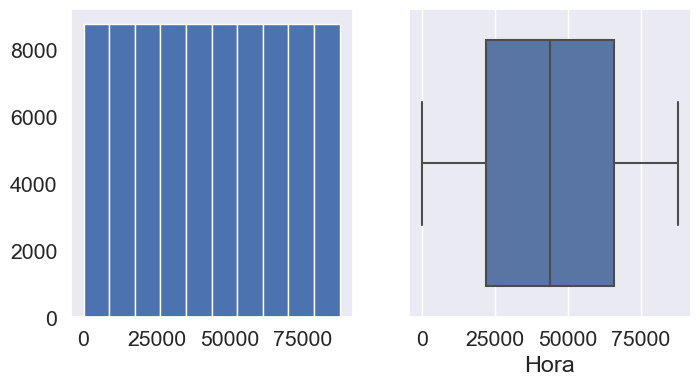

Column:  dir_viento
Skew: -0.86
Kurtosis:  -0.82


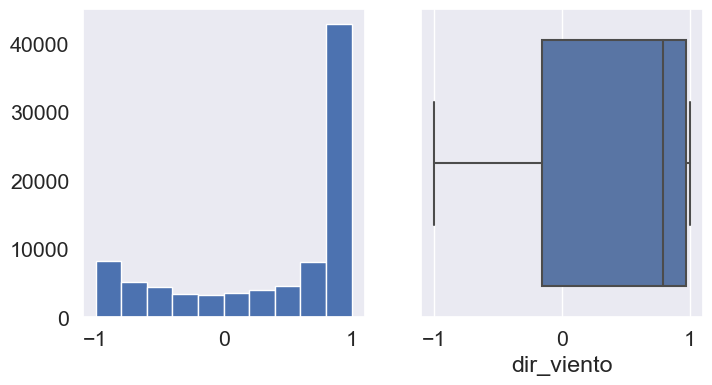

Column:  vel_viento
Skew: 0.37
Kurtosis:  -0.11


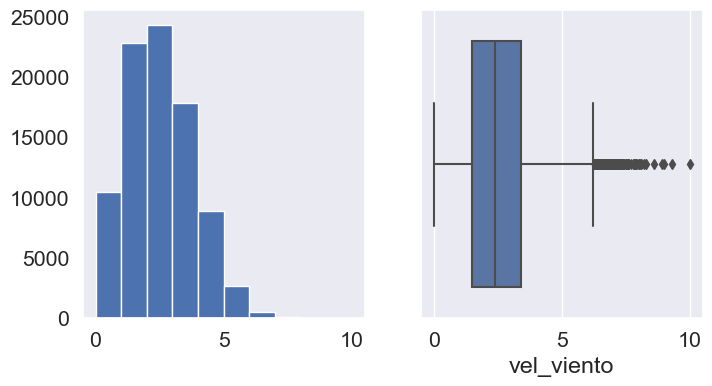

Column:  Humedad rel. máx
Skew: -0.48
Kurtosis:  -0.78


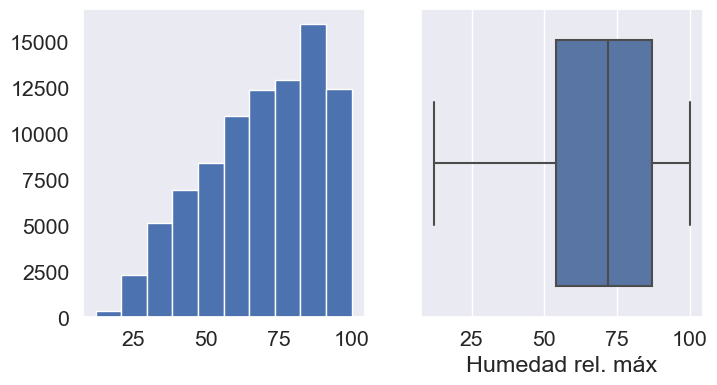

Column:  Humedad rel. mín.
Skew: -0.23
Kurtosis:  -0.96


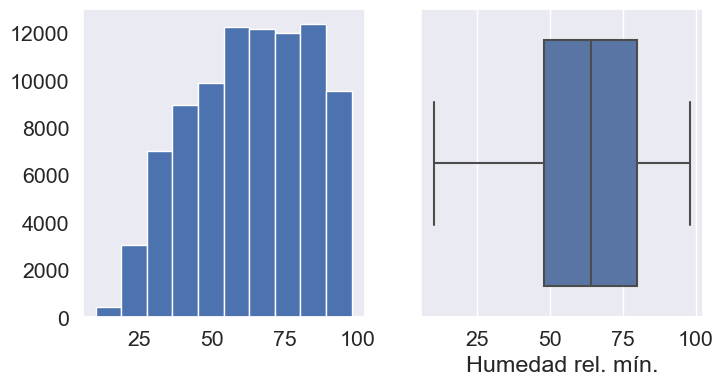

Column:  Temp. máx
Skew: 0.26
Kurtosis:  -0.42


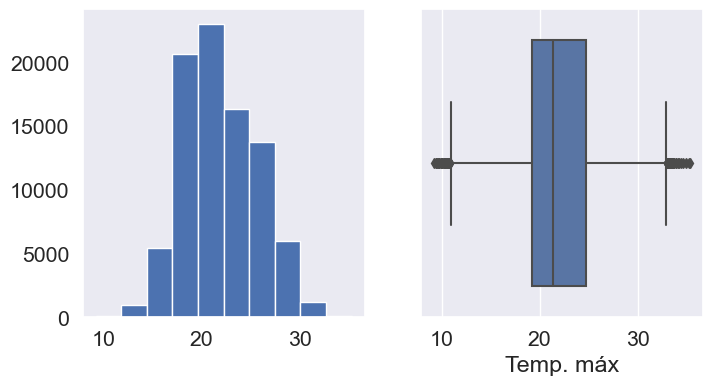

Column:  Temp mín.
Skew: 0.24
Kurtosis:  -0.12


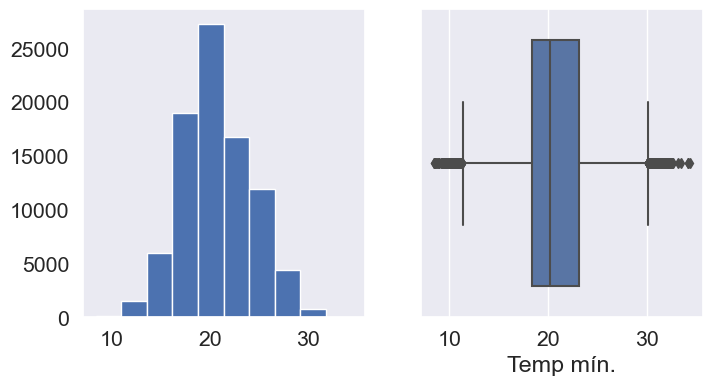

Column:  Humedad rel horaria
Skew: -0.35
Kurtosis:  -0.89


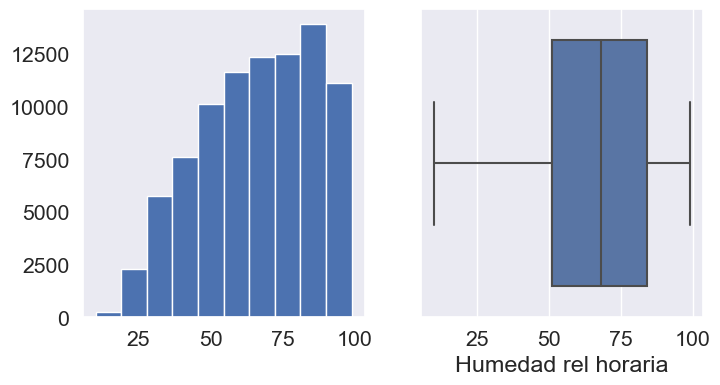

Column:  Presión atm
Skew: 6.18
Kurtosis:  179.64


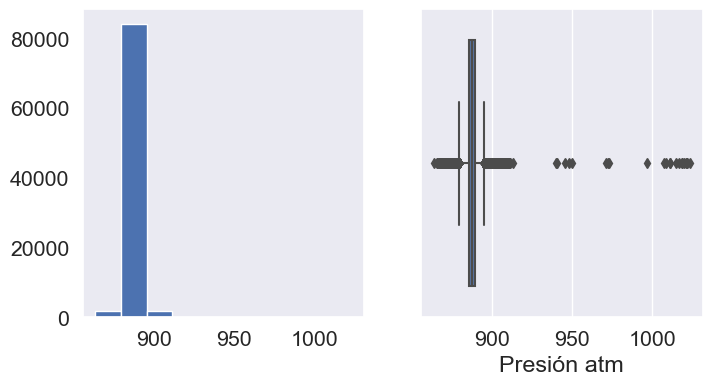

Column:  Precip
Skew: 17.65
Kurtosis:  476.4


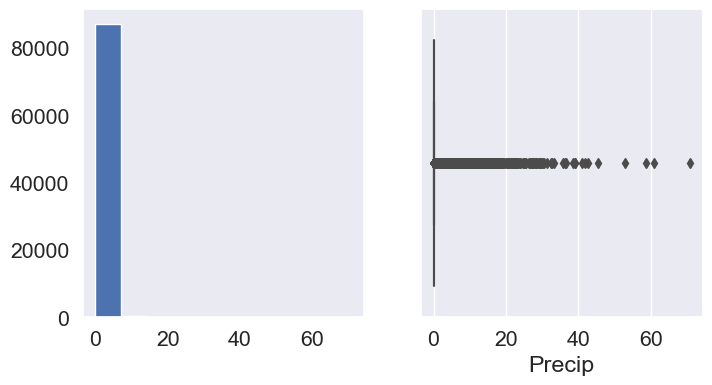

Column:  Máx ráfaga
Skew: 0.41
Kurtosis:  0.11


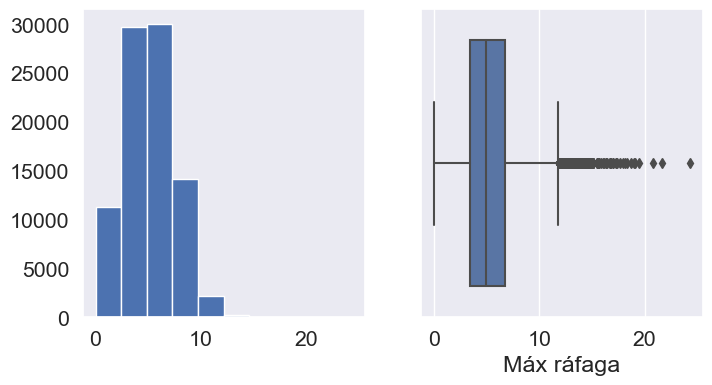

Column:  Presión atm máx
Skew: 1.02
Kurtosis:  5.82


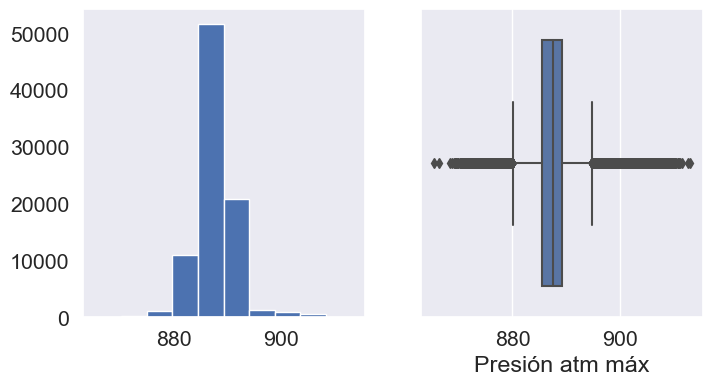

Column:  Presión atm mín
Skew: 0.33
Kurtosis:  4.91


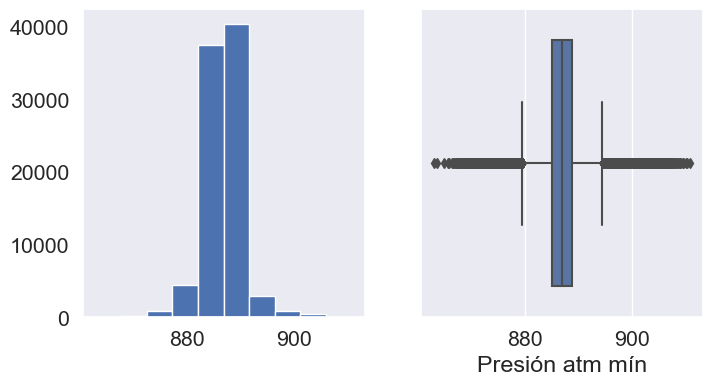

In [146]:
from scipy.stats import kurtosis
num_cols = wind_speed.select_dtypes(include=np.number).columns.tolist()

sns.set(font_scale=1.4)
for col in num_cols:
    print('Column: ', col)
    print('Skew:', round(wind_speed[col].skew(), 2))
    print('Kurtosis: ', round(wind_speed[col].kurtosis(), 2))
    plt.figure(figsize = (8, 4))
    plt.subplot(1, 2, 1)
    wind_speed[col].hist(grid=False)
    plt.subplot(1, 2, 2)
    sns.boxplot(x=wind_speed[col])
    plt.show()

* Se observa que la  dirreccion del viento tiene un sesgo hacia la derecha. 
* Mientras que la velocidad del viento, la variable a predecir tiene un sesgo hacia la izquierda, con varios outlayer en el margen superior. Al igual que la varible rafaga de viento.
* Tanto la presion atmosferica maxima como minima tienen una distribucion casi simetrica.
* En la precipitacion nos encontramos con una distribucion con un fuerte sesgo.

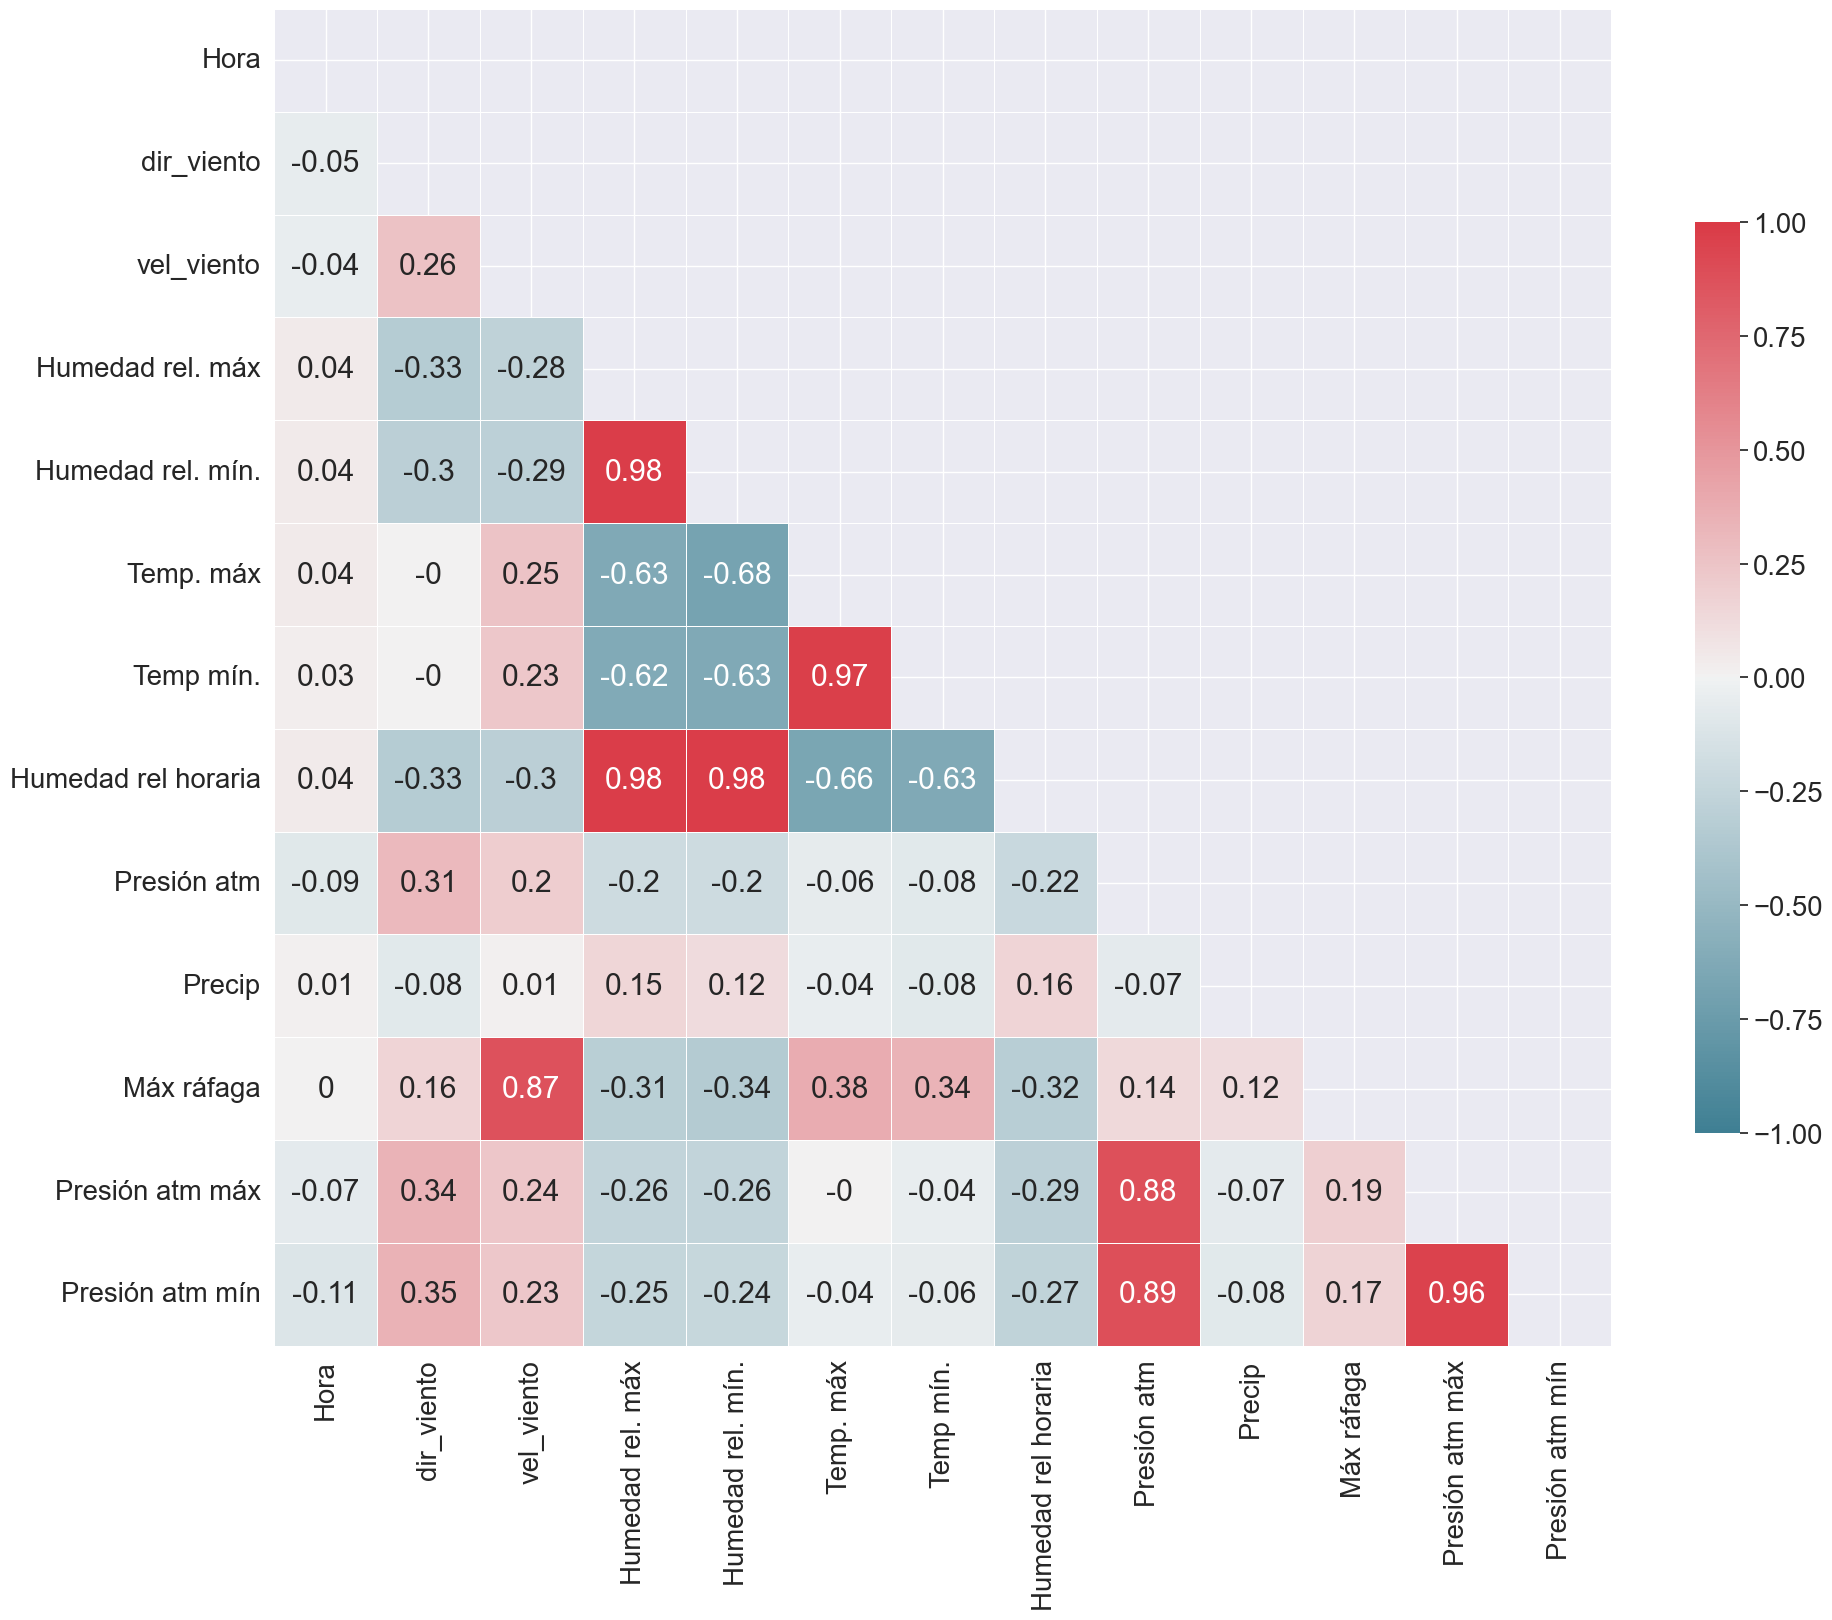

In [147]:
corr = wind_speed.corr().round(2)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.8)
f, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()
    

* Se aplica la funcion VIF con la cual nos quedamos con solo 5 Variables.

In [148]:
from statsmodels.stats.outliers_influence import variance_inflation_factor


X_wind = wind_speed.drop(columns='vel_viento') # Reemplaza con tus nombres de columna

columnas = X.columns


In [149]:
def vif_c(X, columnas):
    vif1 = pd.DataFrame()
    vif1["Variable"] = columnas
    vif1["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif1

contador = 10
while contador > 5:
    vif1 = vif_c(X_wind, columnas)
    indice_max_vif = vif1['VIF'].idxmax()
    
    # Elimina la columna con el VIF máximo en X_wind
    X_wind = X_wind.drop(columns=columnas[indice_max_vif])
    
    # Actualiza la lista de columnas
    columnas = X_wind.columns.tolist()
    
    contador = vif1['VIF'].max()



In [150]:
vif1

Variable       VIF
0               Hora  3.642504
1         dir_viento  1.391809
2  Humedad rel. mín.  4.335346
3             Precip  1.041362
4         Máx ráfaga  4.045375

In [151]:
wind_merge = X_wind.merge(wind_speed[['vel_viento']].copy(), left_index=True, right_index=True)


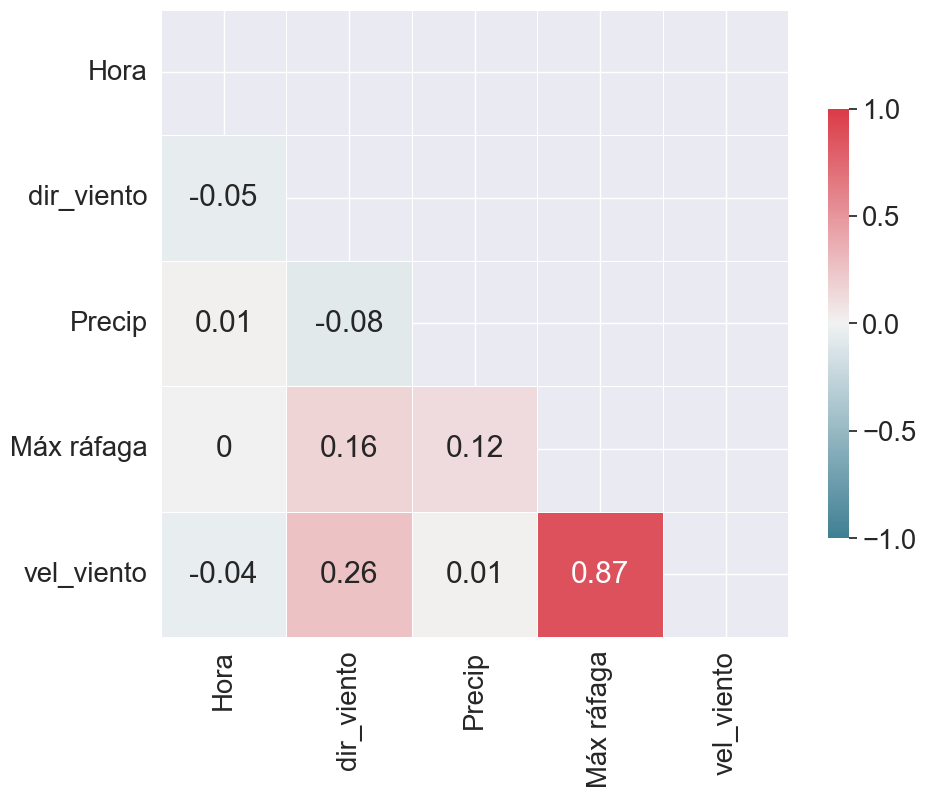

In [152]:
corr = wind_merge.corr().round(2)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

sns.set(font_scale=1.8)
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, square=True, linewidths=.5,
            cbar_kws={"shrink": .5}, annot=True)
plt.tight_layout()

* Efectivamente podemos ver que las variables no se encuentran correlacionadas.

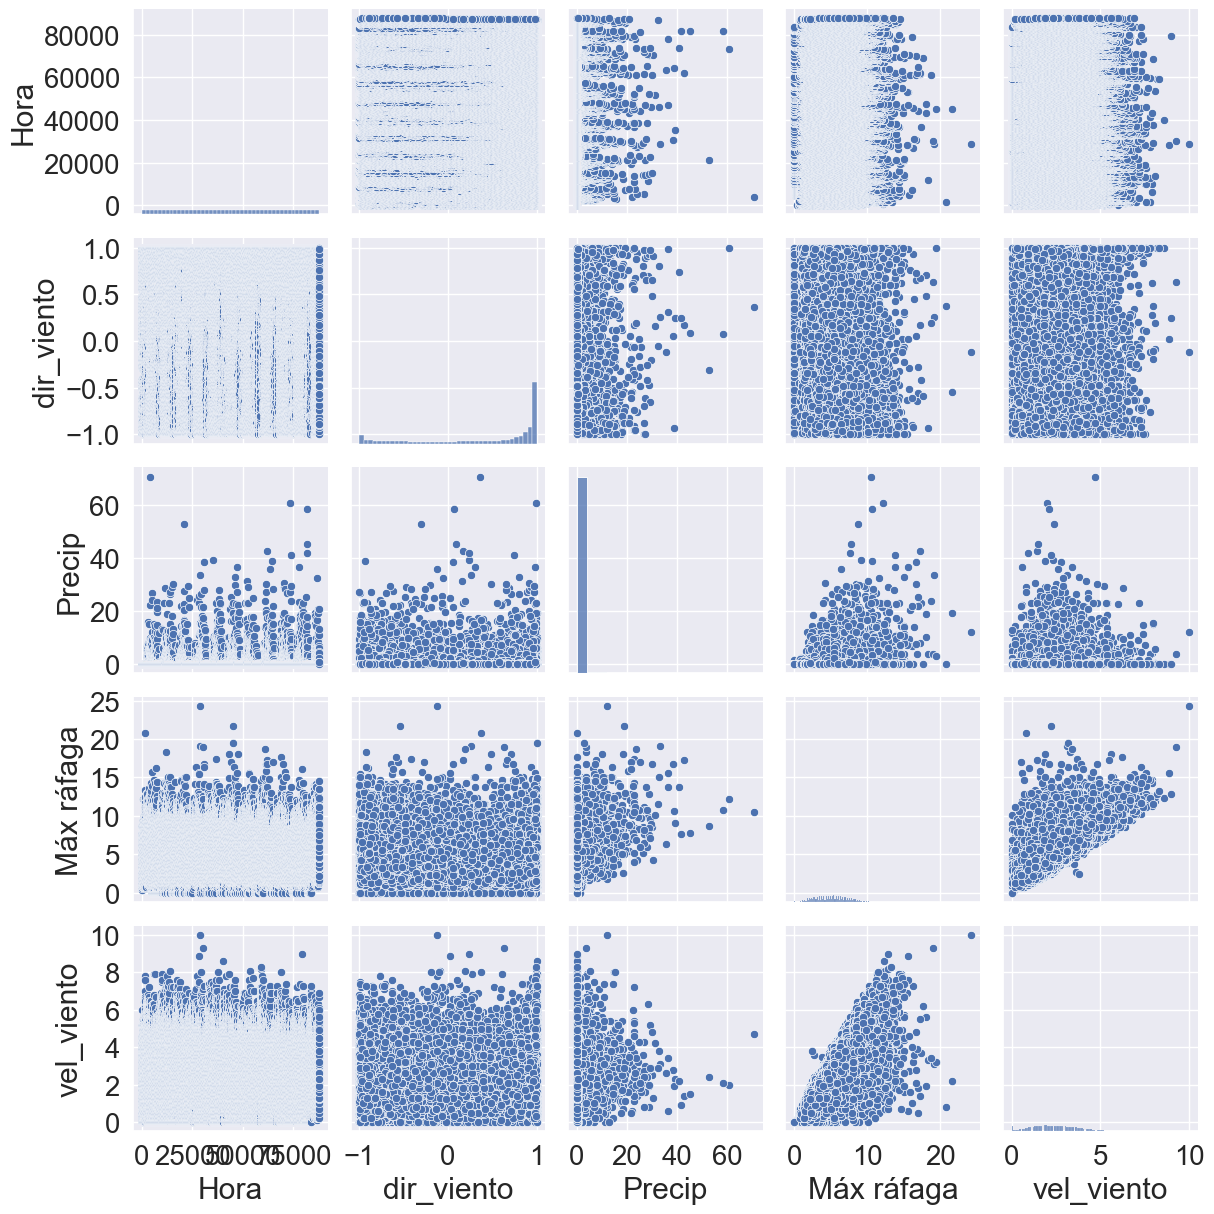

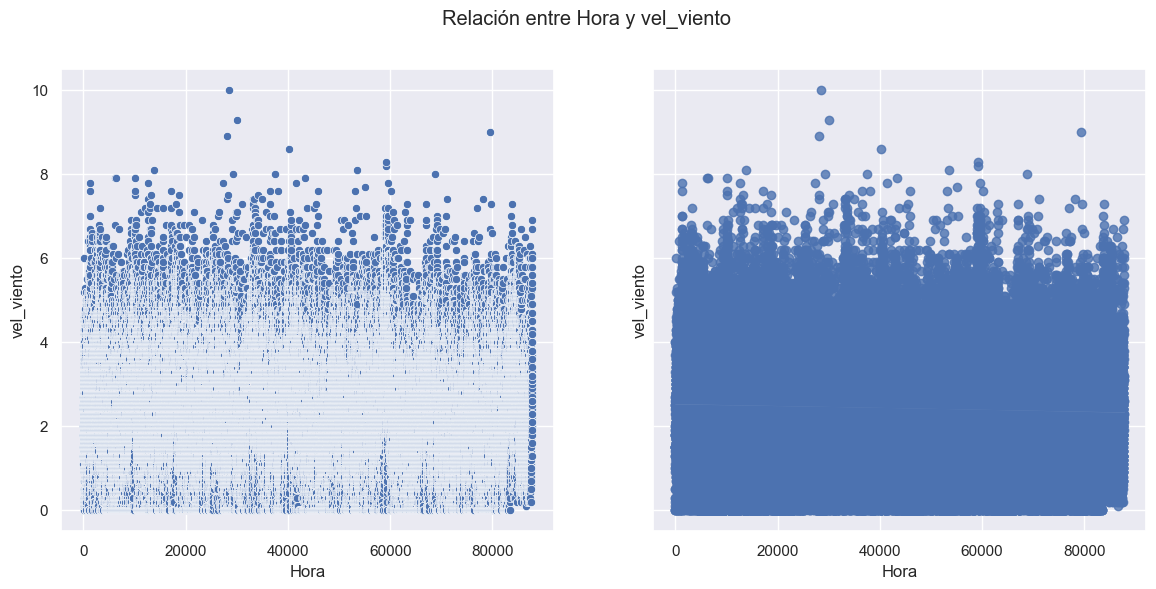

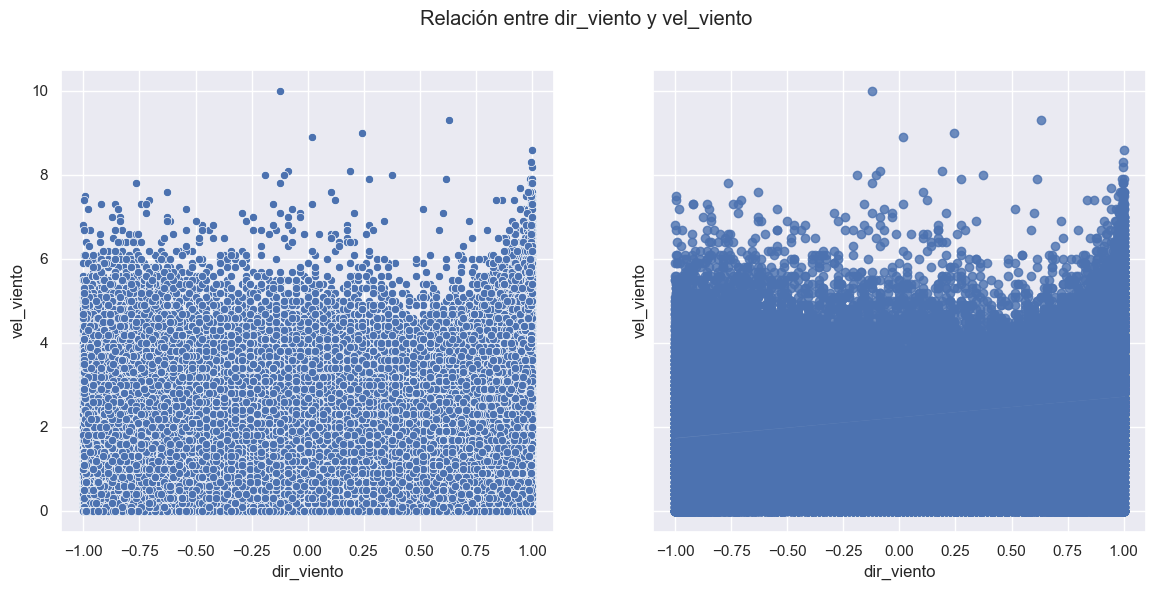

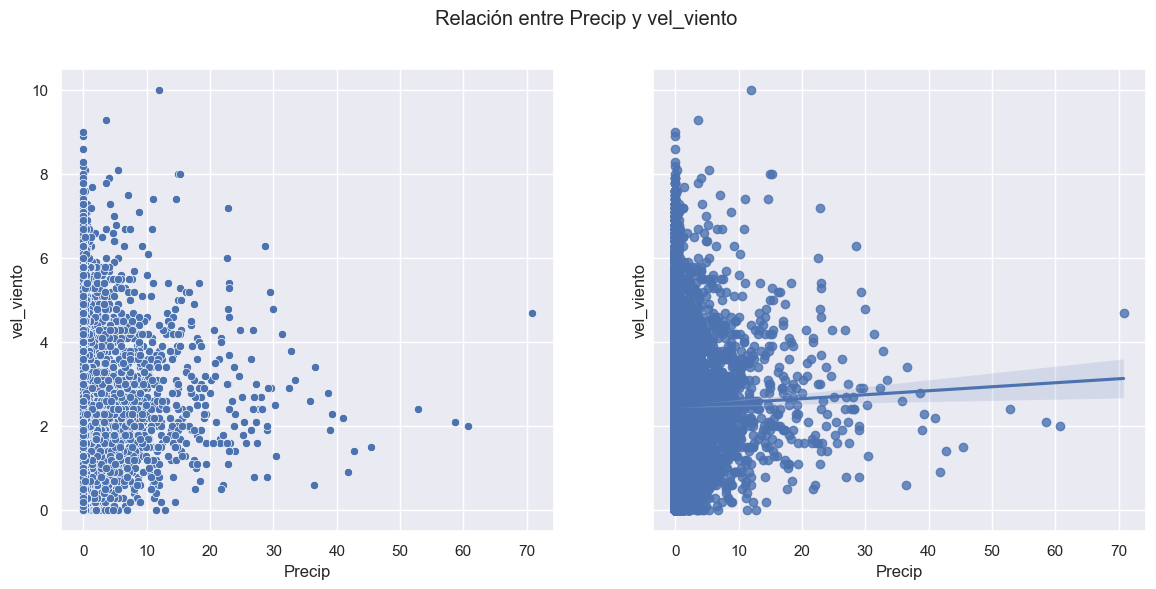

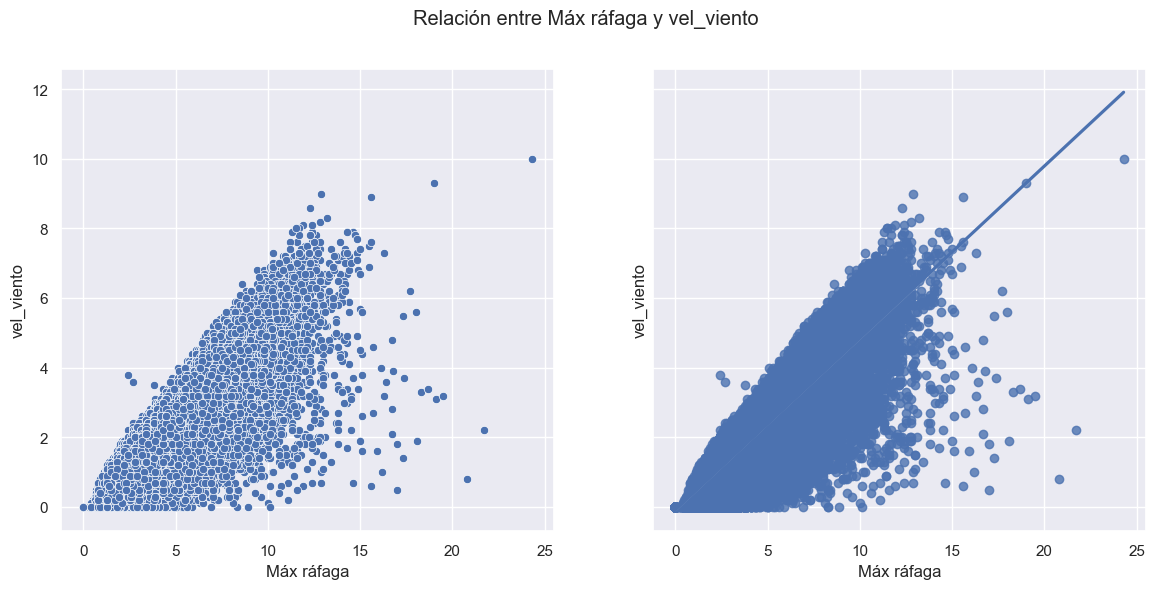

In [153]:
sns.pairplot(data=wind_merge);

num_cols = wind_merge.select_dtypes(include=np.number).columns.tolist()

def scatter_regplot(data, strx, stry):
    sns.set(font_scale=1)
    fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    sns.scatterplot(data=data, x=strx, y=stry, ax=ax[0])
    sns.regplot(data=data, x=strx, y=stry, ax=ax[1]);
    fig.suptitle('Relación entre %s y vel_viento'%col)
    sns.set(font_scale=1)  # Puedes ajustar el valor según tu preferencia

num_cols.remove('vel_viento')
for col in num_cols:
    scatter_regplot(wind_merge, col, 'vel_viento')

* No se puede apreciar una correlacion entre la hora y la direccion del viento con la velocidad del viento. Por otro lado, Se aprecia una fuerte correlaccion entre la rafaga y la velocidad del viento.

## Modelo de Clasificacion

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report


In [ ]:
X = train_fraud(columns = ["isFraud"])
y = train_fraud(columns = ["isFraud"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

### K-NN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'kneighborsregressor__n_neighbors': [1,2,4,6,8,10]}

pipe = make_pipeline(StandardScaler(), )

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)



NameError: name 'make_pipeline' is not defined

In [ ]:
print("Best estimator:\n{}".format(grid.best_estimator_))

In [ ]:
y_pred = grid.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["not Fraud", "Fraud"]))


### Ridge

In [ ]:
from sklearn.linear_model import RidgeClassifier

param_grid = {'kneighborsregressor__n_neighbors': [1,2,4,6,8,10]}

pipe = make_pipeline(StandardScaler(), )

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

### Lasso

In [ ]:
from sklearn.linear_model import Lasso

### Naive Bayes

### XGBoost

### SVM

### MLP

In [ ]:
###

## Modelo de regresion

##### Modelos

* Se hara la funcion para generar los x_trainval, y_trainval

In [154]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

* Se reducira el conjunto de entrenamiento para poder realizar el entrenamiento.

In [155]:
X_wind = X_wind
y_wind = wind_speed[['vel_viento']].copy()

In [156]:
x_wind_c = X_wind
y_wind_c = y_wind

In [157]:
# Calcular la mitad del número de filas (redondeando hacia arriba)
mitad = len(X_wind) // 2 + len(X_wind) % 2

# Seleccionar la primera mitad de filas
X_wind = X_wind[:mitad]
y_wind = y_wind[:mitad]

In [158]:
def metricas(y_test, y_pred):
    # Calcular el RRMSE directamente
    mse = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mse)

    
    return RMSE

In [159]:
y_wind_test = y_wind.tail(24)
y_wind_trainval = y_wind[:-24]
X_wind_test = X_wind.tail(24)
X_wind_trainval = X_wind[:-24]


#### Metricas

In [180]:
#Crear un DataFrame inicial con columnas
data = {'Modelo': [],
        'MAPE':[],
        'RMSE':[],
        'R2': []}

regresion_modelos = pd.DataFrame(data)



In [171]:

def metricas_completas(y_test, y_pred):
    
    # 1. Calcula el error absoluto porcentual (APE)
    APE = np.abs((y_test - y_pred) / y_test) * 100

    # 2. Calcula el MAPE promediando los APEs
    MAPE = np.mean(APE)
    
    mse = mean_squared_error(y_test, y_pred)
    RMSE = np.sqrt(mse)
    
    # Calcular R-squared
    r2 = r2_score(y_test, y_pred)
    # print(f"R-squared (R^2): {r2:.2f}")
    
    return MAPE, RMSE, r2
    
    

In [131]:
regresion_modelos

Empty DataFrame
Columns: [Modelo, MAPE, RMSE, R2]
Index: []

### K-NN

In [120]:

# Valores de k 
valores_k = [1, 2, 3, 4, 5, 6]
valores_rmse = []

for k in valores_k:
    
    
    rmse_list = []
    for j in range(int(len(y_wind_trainval) / (24))):

        i = (j+1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i+24]
        y_wind_val = y_wind_trainval[i:i+24]  
        
        reg = KNeighborsRegressor(n_neighbors=k)
        reg.fit(X_wind_train, y_wind_train)
        y_pred = reg.predict(X_wind_val)
        
        # Calcular el RMSE para esta ventana
        rmse = metricas(y_wind_val, y_pred)
        
        rmse_list.append(rmse)
        
        print(f'k={k}, Ventana {j+1}, RMSE={rmse}')
        

    valores_rmse.append((k, np.mean(rmse_list)))
        

k=1, Ventana 1, RMSE=1.0630424044858338
k=1, Ventana 2, RMSE=0.513237834488962
k=1, Ventana 3, RMSE=0.2924424127923128
k=1, Ventana 4, RMSE=0.23340587185351003
k=1, Ventana 5, RMSE=0.37135950003991286
k=1, Ventana 6, RMSE=0.3659102534735703
k=1, Ventana 7, RMSE=0.9955776054725811
k=1, Ventana 8, RMSE=0.48490709210568794
k=1, Ventana 9, RMSE=0.7299434718712603
k=1, Ventana 10, RMSE=0.3621031001039405
k=1, Ventana 11, RMSE=0.4365121792717984
k=1, Ventana 12, RMSE=0.4960681017400851
k=1, Ventana 13, RMSE=0.40909517902226433
k=1, Ventana 14, RMSE=0.29157875912457365
k=1, Ventana 15, RMSE=0.8128763439634004
k=1, Ventana 16, RMSE=0.932878550868522
k=1, Ventana 17, RMSE=1.1210476925599921
k=1, Ventana 18, RMSE=0.9812436488504597
k=1, Ventana 19, RMSE=0.6984606089266754
k=1, Ventana 20, RMSE=0.6814982445935753
k=1, Ventana 21, RMSE=0.6097560908197077
k=1, Ventana 22, RMSE=0.9065551726903639
k=1, Ventana 23, RMSE=0.6946764412492299
k=1, Ventana 24, RMSE=0.34812610335247557
k=1, Ventana 25, RMSE

In [161]:
valores_rmse

[(1, 0.6283693438997552),
 (2, 0.609607258798121),
 (3, 0.6023096129106221),
 (4, 0.5969219138792256),
 (5, 0.5924329742907845),
 (6, 0.5872596082202497)]

In [172]:
reg = KNeighborsRegressor(n_neighbors=6)

reg.fit(X_wind_trainval, y_wind_trainval)
y_pred = reg.predict(X_wind_test)
        
# Calcular el RMSE para esta ventana
MAPE, RMSE, R2 = metricas_completas(y_wind_test, y_pred)

In [181]:
nueva_fila = {'Modelo': 'k-NN', 'MAPE': MAPE, 'RMSE': RMSE , 'R2': R2}
regresion_modelos = pd.concat([regresion_modelos , pd.DataFrame([nueva_fila])], ignore_index=True)

In [182]:
regresion_modelos

Modelo       MAPE      RMSE       R2
0   k-NN  66.379439  2.243726 -2.42086

### Ridge

In [122]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import Ridge

In [187]:
# Valores de alpha
n_alphas = 100
alphas = np.logspace(-10, -2, n_alphas)
valores_rmse = []

for a in alphas:
    
    
    rmse_list = []
    for j in range(int(len(y_wind_trainval) / (24))):

        i = (j+1) * 24
        X_wind_train = X_wind_trainval[:i]
        y_wind_train = y_wind_trainval[:i]
        X_wind_val = X_wind_trainval[i:i+24]
        y_wind_val = y_wind_trainval[i:i+24]  
        
        reg = Ridge(alpha=a , fit_intercept=False)
        reg.fit(X_wind_train, y_wind_train)
        y_pred = reg.predict(X_wind_val)
        
        # Calcular el RMSE para esta ventana
        rmse = metricas(y_wind_val, y_pred)
        
        rmse_list.append(rmse)
        
        print(f'k={a}, Ventana {j+1}, RMSE={rmse}')
        

    valores_rmse.append((a, np.mean(rmse_list)))
        

k=1e-10, Ventana 1, RMSE=1.0174983678107192
k=1e-10, Ventana 2, RMSE=0.36463955865499265
k=1e-10, Ventana 3, RMSE=0.5633473436132395
k=1e-10, Ventana 4, RMSE=0.5208666717621439
k=1e-10, Ventana 5, RMSE=0.45169316130383685
k=1e-10, Ventana 6, RMSE=0.47292083827316816
k=1e-10, Ventana 7, RMSE=0.7729146062022729
k=1e-10, Ventana 8, RMSE=0.625411695952035
k=1e-10, Ventana 9, RMSE=0.5412160572565234
k=1e-10, Ventana 10, RMSE=0.4944223740944842
k=1e-10, Ventana 11, RMSE=0.44277960129032873
k=1e-10, Ventana 12, RMSE=0.5864391265299564
k=1e-10, Ventana 13, RMSE=0.6699513684553939
k=1e-10, Ventana 14, RMSE=0.595289045301746
k=1e-10, Ventana 15, RMSE=0.6945321990142761
k=1e-10, Ventana 16, RMSE=0.5247721674349775
k=1e-10, Ventana 17, RMSE=0.5356146717989531
k=1e-10, Ventana 18, RMSE=0.6786367360587574
k=1e-10, Ventana 19, RMSE=0.5600588401499323
k=1e-10, Ventana 20, RMSE=0.6399041891948605
k=1e-10, Ventana 21, RMSE=0.4148898714620893
k=1e-10, Ventana 22, RMSE=0.5129202068573324
k=1e-10, Ventana 

KeyboardInterrupt: 

### Lasso

### Naive Bayes

### XGBoost

### SVM

### MLP

In [ ]:
###